# Tree-Based Models for Intrusion Detection (CICIDS2017 Dataset)

This notebook focuses on preparing the dataset, cleaning it, splitting into training and testing parts, and then applying feature selection and model training.

## 1. Data Preprocessing

### 1.1 Import Libraries

This block imports the warnings module and disables warning messages. It ensures that the notebook output remains clean and readable without unnecessary warning texts during execution.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Here we import the required Python libraries:

- `numpy` and `pandas` for numerical operations and data manipulation  
- `seaborn` and `matplotlib` for visualization  
- `LabelEncoder` from scikit-learn to convert categorical labels into numeric form  
- `train_test_split` for dataset splitting  
- `classification_report`, `confusion_matrix`, `accuracy_score`, `precision_recall_fscore_support`, `f1_score` for model evaluation  
- `DecisionTreeClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier`, and `XGBoost` for classification models  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

### 1.2 Load Dataset

The sampled CICIDS2017 dataset is loaded into a pandas DataFrame (df) from a CSV file.

In [ ]:
df = pd.read_csv('C:/Users/hp/Downloads/final/Intelligent Intrusion Detection System/Intrusion Detection system/Intrusion-Detection/data/CICIDS2017_sa.csv')

### 1.3 Normalization and Missing Values

Min-Max Normalization is applied to all numeric features, scaling values between 0 and 1. This step ensures uniformity across features, preventing large-scale values from dominating smaller ones. Missing values are replaced with 0 for consistency.

In [ ]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### 1.4 Train/Test Split

The `Label` column (attack type) is encoded into numeric values using `LabelEncoder`.  

- `X` contains the independent variables (features).  
- `y` contains the target class labels (dependent variable).  

The dataset is split into **80% training** and **20% testing**, with `stratify=y` ensuring that class distribution remains consistent across both sets.

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

Displays the dimensions (rows and columns) of the training dataset to confirm successful splitting and preprocessing.

In [ ]:
X_train.shape

(45328, 77)

Shows the dimensions of the test dataset, ensuring the split is correct.

In [ ]:
X_test.shape

(11333, 77)

Counts and displays the frequency of each class in the training dataset. This helps identify class imbalance problems before applying resampling methods.

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### 1.5 Handling Imbalanced Data (SMOTE)

SMOTE (Synthetic Minority Oversampling Technique) is imported and initialized.

It generates synthetic samples for under-represented classes to balance the dataset. In this case, class 4 is oversampled to create 1500 new examples.

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1, sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

This block checks the type, shape, and unique values of y_train. It validates that the labels are encoded properly and ready for training.

In [ ]:
print(type(y_train))
print(y_train.shape)
print(np.unique(y_train)[:10])   # show first 10 unique labels


<class 'numpy.ndarray'>
(45328,)
[0 1 2 3 4 5 6]


The training labels (y_train) are encoded again to ensure consistency. Then, SMOTE is applied to oversample the minority classes. 

This balances the training dataset and helps machine learning models perform better on imbalanced data.

In [ ]:
y_train =labelencoder.fit_transform(y_train)
X_train, y_train = smote.fit_resample(X_train, y_train)

Displays the new class distribution in the training dataset after SMOTE.

This verifies whether oversampling successfully balanced the dataset.

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## 2. Model Training and Evaluation (Before Feature Selection)

### 2.1 Decision Tree

A Decision Tree classifier is initialized and trained using the resampled training data.  
Predictions are made on the test set, and the true labels are encoded for evaluation.


Accuracy of DT: 0.995764581311215
Precision of DT: 0.9958704389239157
Recall of DT: 0.995764581311215
F1-score of DT: 0.9957992382059783
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.60      0.86      0.71         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.94      0.97      0.95     11333
weighted avg       1.00      1.00      1.00     11333



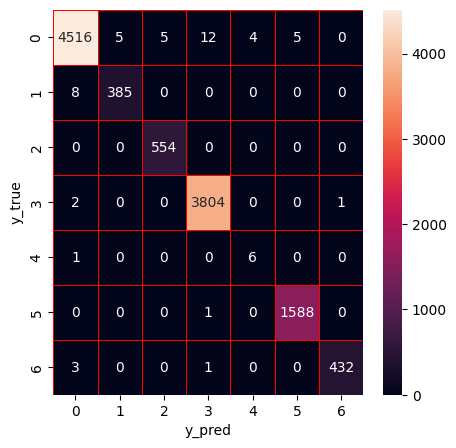

In [ ]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)

y_predict=dt.predict(X_test)
y_true=y_test
y_true_encoded=labelencoder.transform(y_true)
print('Accuracy of DT: '+ str(dt.score(X_test,y_true_encoded)))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_encoded, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true_encoded,y_predict))
cm=confusion_matrix(y_true_encoded,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Predictions are generated for both training (`dt_train`) and test (`dt_test`) sets.  
These are later used to compare model performance and check for overfitting.


In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

### 2.2 Random Forest

A Random Forest classifier is trained.  
Random Forest is an ensemble method that combines multiple decision trees for better accuracy and robustness.  
Predictions are made on the test dataset.


Accuracy of RF: 0.9948822024177182
Precision of RF: 0.9949085648906869
Recall of RF: 0.9948822024177182
F1-score of RF: 0.9948656587738048
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.98      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



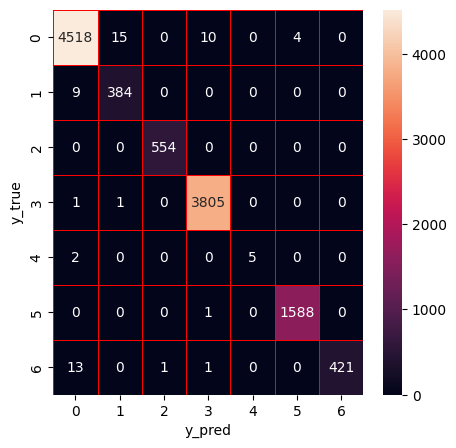

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)

y_predict=rf.predict(X_test)
y_true=y_test
y_true_encoded=labelencoder.transform(y_true)
print('Accuracy of RF: '+ str(rf.score(X_test,y_true_encoded)))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_encoded, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true_encoded,y_predict))
cm=confusion_matrix(y_true_encoded,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Predictions are generated for both training (`rf_train`) and test (`rf_test`) sets.  
This allows comparison between model fitting and generalization.


In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

### 2.3 Extra Trees

An Extra Trees classifier is trained.  
Similar to Random Forest, Extra Trees builds multiple trees but introduces more randomness.  
The model is evaluated by printing its accuracy on the test dataset.


Accuracy of ET: 0.9925880172946263
Precision of ET: 0.9925999600547237
Recall of ET: 0.9925880172946263
F1-score of ET: 0.9925697851766749
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



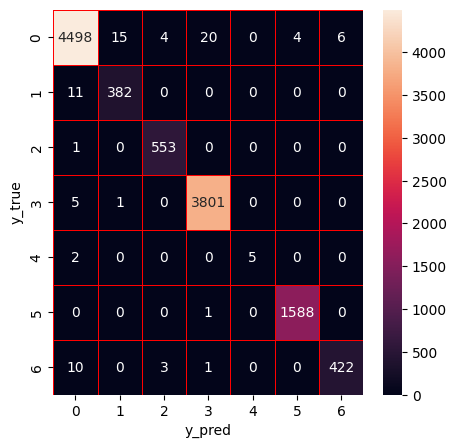

In [ ]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
y_predict=et.predict(X_test)
y_true=y_test
y_true_encoded=labelencoder.transform(y_true)
print('Accuracy of ET: '+ str(et.score(X_test,y_true_encoded)))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_encoded, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true_encoded,y_predict))
cm=confusion_matrix(y_true_encoded,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Predictions for both training (`et_train`) and test (`et_test`) sets are obtained.  
This is useful for performance evaluation and overfitting detection.


In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### 2.4 XGBoost

The XGBoost classifier is initialized with 10 estimators and trained on the training data.  
XGBoost is a powerful boosting algorithm often used in intrusion detection tasks.  
Predictions are generated for the test set.


Accuracy of XGBoost: 0.99435277508162
Precision of XGBoost: 0.9943416294473314
Recall of XGBoost: 0.99435277508162
F1-score of XGBoost: 0.994334815275237
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



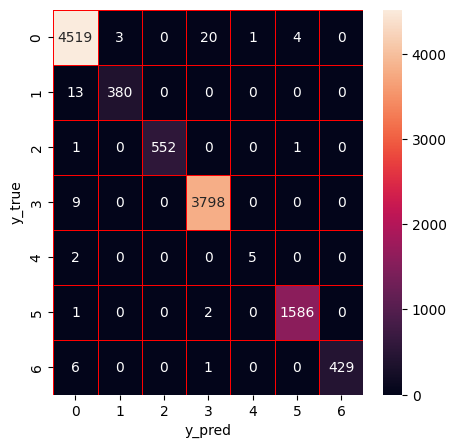

In [ ]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)

y_predict=xg.predict(X_test)
y_true=y_test
y_true_encoded=labelencoder.transform(y_true)
print('Accuracy of XGBoost: '+ str(xg.score(X_test,y_true_encoded)))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_encoded, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true_encoded,y_predict))
cm=confusion_matrix(y_true_encoded,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training (`xg_train`) and test (`xg_test`) predictions are collected from the XGBoost model.  
These will be used later for model evaluation and comparison.


In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### 2.5 Stacking Model Construction (Ensemble for 4 base learners)

The outputs of the four base models (Decision Tree, Random Forest, Extra Trees, and XGBoost)  are combined into a new DataFrame. These predictions will later be used to construct an ensemble (stacking) model.


In [ ]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


Each model’s predictions are reshaped into column vectors.  
This ensures they can be concatenated properly when creating the input for the stacking model.


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

Predictions from the four models are concatenated into a single feature set (`x_train` and `x_test`).  
These combined predictions serve as input features for the stacking classifier.


In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

An XGBoost classifier (`stk`) is trained using the combined predictions of the four base models.  
This forms the **stacking ensemble model**, which learns from the strengths of all models.


In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Predictions are made using the stacking model.  
The accuracy, precision, recall, and F1-score of the ensemble are calculated and printed.  
This helps evaluate the effectiveness of stacking compared to individual models.


Accuracy of Stacking: 0.9956763434218654
Precision of Stacking: 0.9956801591780816
Recall of Stacking: 0.9956763434218654
F1-score of Stacking: 0.9956584193838331
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



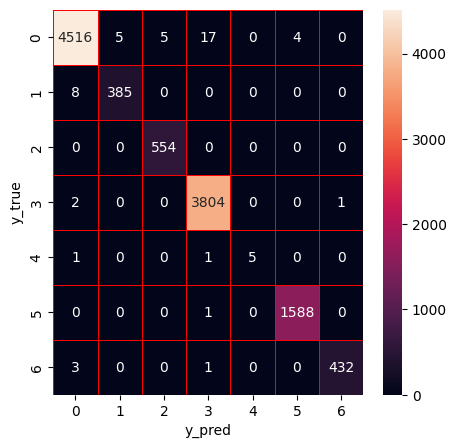

In [ ]:
y_predict=stk.predict(x_test)
y_true=y_test
y_true_encoded=labelencoder.transform(y_true)
stk_score=accuracy_score(y_true_encoded,y_predict)
print('Accuracy of Stacking: '+ str(accuracy_score(y_true_encoded,y_predict)))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_encoded, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true_encoded,y_predict))
cm=confusion_matrix(y_true_encoded,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()